In [124]:
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.callbacks import TensorBoard
from time import time

In [125]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [126]:
# dataframe = read_csv('sp500.csv')
fields = ['open', 'close']
dataframe = read_csv('log_inf_small.csv', skipinitialspace = True, squeeze = True, usecols = fields)

print(dataframe.head())
data = np.array(dataframe[:1000])

       open     close
0    254.00    253.90
1   1651.15   1654.20
2    254.45    253.95
3  25100.00  25056.35
4    845.00    842.50


In [127]:
# dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data[:5])

[[0.00302212 0.00303566]
 [0.05211935 0.05252147]
 [0.00303794 0.00303742]
 [0.87613505 0.87954023]
 [0.02379045 0.02383645]]


In [128]:
split = 0.67
train_size = int(len(data)*split)
test_size = len(data)-train_size
train = data[0:train_size,:]
test = data[train_size:len(data),:]
print(train[:5])

[[0.00302212 0.00303566]
 [0.05211935 0.05252147]
 [0.00303794 0.00303742]
 [0.87613505 0.87954023]
 [0.02379045 0.02383645]]


In [129]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainY.shape)
# print(trainY[:5])

(666, 2)


In [130]:
# trainX = np.reshape(trainX, (trainX.shape[0], 2, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 2, testX.shape[1]))

In [131]:
units = 100
drop = 0.2
epoch = 20

model = Sequential()
model.add(LSTM(units, input_shape=(look_back, 2)))
# model.add(Dropout(drop))
model.add(Dense(2))
# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='nadam')
model.summary()
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=1, callbacks=[tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
Total params: 41,402
Trainable params: 41,402
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
666/666 [==============================] - 4s 6ms/step - loss: 0.0535
Epoch 2/20
666/666 [==============================] - 4s 6ms/step - loss: 0.0532
Epoch 3/20
666/666 [==============================] - 4s 6ms/step - loss: 0.0529
Epoch 4/20
666/666 [==============================] - 4s 6ms/step - loss: 0.0531
Epoch 5/20
666/666 [==============================] - 4s 6ms/step - loss: 0.0528
Epoch 6/20
666/666 [==============================] - 4s 6ms/step - loss: 0.0527
Epoch 7/20
666/666 [============================

In [132]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# print(trainY.shape)

In [133]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)


In [134]:
# print(trainY.shape)
# print(trainPredict.shape)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 6482.63 RMSE
Test Score: 7002.22 RMSE


In [135]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict


In [136]:
print(data.shape)
print(train.shape)
print(test.shape)
print(trainPredict.shape)
print(testPredict.shape)

(1000, 2)
(670, 2)
(330, 2)
(666, 2)
(326, 2)


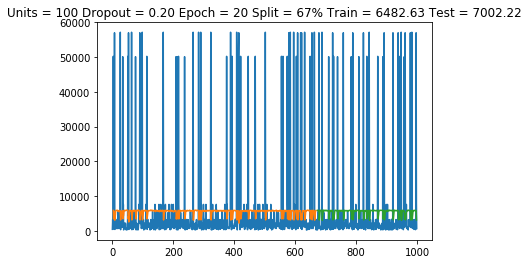

In [137]:
plt.plot(np.sum(scaler.inverse_transform(data), axis = 1))
plt.plot(np.sum(trainPredictPlot, axis = 1))
plt.plot(np.sum(testPredictPlot, axis = 1))
plt.title('Units = %d Dropout = %.2f Epoch = %d Split = %d%% Train = %.2f Test = %.2f' % 
		(units, drop, epoch, split*100, trainScore, testScore))
plt.show()